In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def xor_dataset(batch_size=1000, device="cpu"):
    x0 = torch.randint(2, (batch_size,), dtype=torch.bool, device=device)
    X = torch.stack([x0, ~x0], dim=1).float()

    return X

In [ ]:
def random_dataset(batch_size=1000, dimensions=2, classes=3, device="cpu"):
    x = torch.randint(classes, (batch_size, dimensions), device=device)
    return x

In [ ]:
class DiscreteBayesianFlow:
    def __init__ (self, model, K=2, D=2, n=100, beta=3.0, lr=1e-3, device="cuda"):
        self.device = device
        self.model = model.to(device)
        self.K = K
        self.D = D
        self.n = n
        self.beta = beta
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)

        self.logs = {}


    def get_beta(self, t):
        return self.beta * (t ** 2.0)


    def get_alpha(self, t):
        return self.beta * (2 * t - 1) / self.n ** 2


    def discrete_output_distribution(self, theta, t):
        theta = theta * 2 - 1
        output_nn = self.model(theta, t)
        output_nn = output_nn.view(output_nn.shape[0], self.D, -1)
        # if self.K == 2:
        #     p_1 = torch.sigmoid(output_nn)
        #     p_2 = 1 - p_1
        #     p = torch.cat([p_1, p_2], dim=-1)
        # else:
        #     p = nn.functional.softmax(output_nn, dim=-1)
        p = nn.functional.softmax(output_nn, dim=-1)
        return p


    def continuous_loss(self, target):
        target = target.to(self.device)

        t = torch.clip(torch.randn((target.size(0),), requires_grad=False, device=self.device, dtype=torch.float32), 1e-5, 1.0)
        beta = self.get_beta(t)

        e_x = nn.functional.one_hot(target.long(), num_classes=self.K).float()
        y_mean = beta[..., None, None] * (self.K * e_x - 1)
        y_std = (beta * self.K).sqrt()[:, None, None]
        eps = torch.randn_like(y_mean).to(self.device)

        y = y_mean + y_std * eps

        theta = nn.functional.softmax(y, dim=-1)
        p_o = self.discrete_output_distribution(theta, t)

        e_hat = p_o
        l_infinity = self.K * self.beta * t[..., None, None] * (e_x - e_hat) ** 2
        l_infinity = l_infinity.mean()
        return l_infinity


    def sample(self, batch_size=64):
        self.model.eval()
        theta = torch.ones((batch_size, self.D, self.K), device=self.device) / self.K

        for i in range(1, self.n+1):
            t = (i - 1) / self.n
            t = t * torch.ones(batch_size, device=self.device, dtype=theta.dtype)
            p_o = self.discrete_output_distribution(theta, t)
            k = torch.distributions.Categorical(probs=p_o).sample()
            alpha = self.get_alpha(i)

            e_k = nn.functional.one_hot(k, num_classes=self.K).float()
            y_mean = alpha * (self.K * e_k - 1)
            y_std = torch.full_like(y_mean, fill_value=(alpha * self.K)).sqrt()
            eps = torch.randn_like(y_mean).to(self.device)
            y = y_mean + y_std * eps
            theta = nn.functional.softmax(y + torch.log(theta + 1e-10), dim=-1)

        p_o = self.discrete_output_distribution(theta, torch.ones_like(t))
        k = torch.distributions.Categorical(probs=p_o).sample()
        return k


    def train(self, dataloader, epochs=20):
        self.logs["loss"] = []
        self.logs["step"] = []
        step = 0
        for epoch in range(epochs):
            for batch in dataloader:
                self.model.zero_grad()
                X = batch[0]
                loss = self.continuous_loss(X)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1)
                self.optimizer.step()
                step += 1

                # logs
                self.logs["loss"].append(loss.item())
                self.logs["step"].append(step)

In [ ]:
class MLPBFS(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=[32, 64, 32]):
        super(MLPBFS, self).__init__()
        layers = []
        for i, h in enumerate(hidden_dim):
            if i==0:
                layers.append(nn.Sequential(
                    nn.Linear(input_dim + 1, h),
                    nn.SiLU()))
            else:
                layers.append((nn.Sequential(
                    nn.Linear(hidden_dim[i-1], h),
                    nn.SiLU())))

        layers.append(nn.Linear(hidden_dim[-1], output_dim))

        self.mlp = nn.Sequential(*layers)


    def forward(self, x, t):
        x = x.view(x.shape[0], -1)
        x_hat = torch.cat((x, t.unsqueeze(-1)), dim=-1)
        return self.mlp(x_hat)

In [ ]:
# Parameters
K = 2
D = 2

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = MLPBFS(K*D, K*D, hidden_dim=[64, 32, 16, 8])
bayesian_flow = DiscreteBayesianFlow(model=model, K=K, D=D, device=device)

In [ ]:
# Crear el dataset
data = xor_dataset(device=device)

# Convertir los datos en un TensorDataset
dataset = TensorDataset(data)

# Crear un DataLoader a partir del TensorDataset
batch_size = 64  # Tamaño del lote
shuffle = True   # Mezclar los datos al cargarlos
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)


In [ ]:
# Entrenar el modelo
bayesian_flow.train(dataloader, epochs=100)

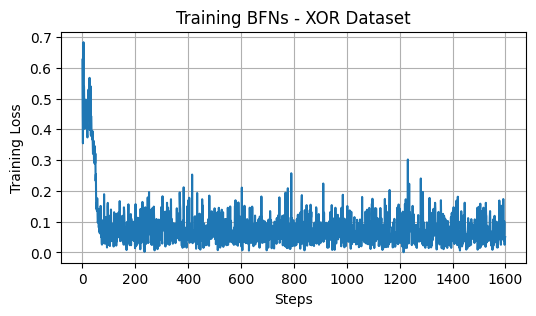

In [ ]:
logs = bayesian_flow.logs

plt.figure(figsize=(6, 3))
plt.xlabel("Steps")
plt.ylabel("Training Loss")
plt.title("Training BFNs - XOR Dataset")
plt.grid()
plt.plot(logs["loss"])

[]

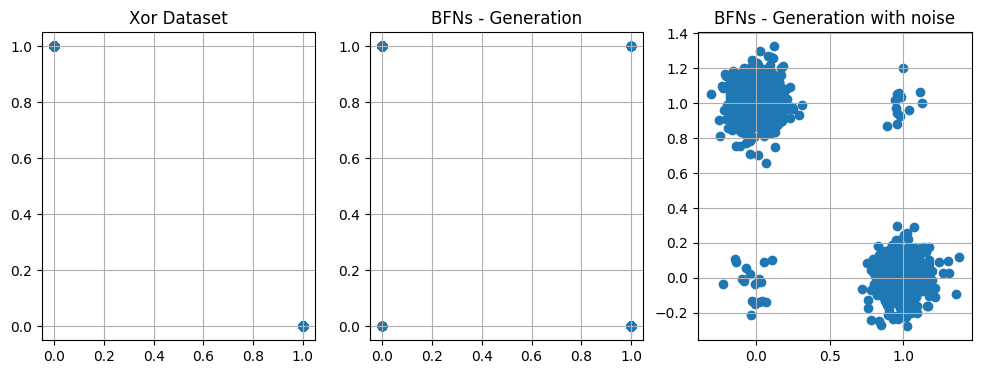

In [ ]:
# Original samples.
x_xor = xor_dataset(batch_size=1000).cpu().numpy()

# Generated distribution with BFNs
x_bfn = bayesian_flow.sample(batch_size=1000).detach().cpu().numpy()

# Generated data with noise
x_noise = x_bfn + (np.random.randn(*x_bfn.shape) * 0.1)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
ax1.scatter(x_xor[:, 0], x_xor[:, 1])
ax2.scatter(x_bfn[:, 0], x_bfn[:, 1])
ax3.scatter(x_noise[:, 0], x_noise[:, 1])

ax1.title.set_text('Xor Dataset')
ax1.grid()
ax2.title.set_text('BFNs - Generation')
ax2.grid()
ax3.title.set_text('BFNs - Generation with noise')
ax3.grid()

plt.plot()

# Generación de palabras

In [ ]:
words = [
    "bayesian",
    "flow",
    "network",
    "networks",
    "generative",
    "model",
    "update",
    "probability",
    "distribution",
    "discrete",
    "continous",
    "divergence",
    "kullback",
    "leibler",
    "loss"
]

vocab_lists = [[char for char in word] for word in words]
vocab = list(set([char for vocab in vocab_lists for char in vocab]))
vocab.insert(0, ' ')

itos = {idx: token for (idx, token) in enumerate(vocab)}
stoi = {token: idx for (idx, token) in itos.items()}

length = max([len(word) for word in words])

In [ ]:
def word_to_idx(word, length):
    chars = [*word]
    pad = [" "] * (length - len(chars))
    chars += pad
    idxs = list(map(lambda x: stoi[x], chars))
    return idxs

In [ ]:
def words_dataset(words_list, max_length, n_samples=1000, device="cpu"):
    n_words = len(words_list)
    words_idxs = np.random.randint(n_words, size=n_samples)
    X = torch.zeros((n_samples, length), device=device)

    for i in range(n_samples):
        word = words_list[words_idxs[i]]
        idxs = word_to_idx(word, max_length)
        X[i] = torch.tensor(idxs)

    return X.float()


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

K = len(vocab)
D = length
words_model = MLPBFS(K * D, K * D, hidden_dim=[64, 32, 16, 8])
words_bayesian_flow = DiscreteBayesianFlow(model=words_model, K=K, D=D, beta=1.0, device=device)

In [ ]:
# Crear el dataset
data = words_dataset(words, length, n_samples=5000, device=device)

# Convertir los datos en un TensorDataset
dataset = TensorDataset(data)

# Crear un DataLoader a partir del TensorDataset
batch_size = 64  # Tamaño del lote
shuffle = True   # Mezclar los datos al cargarlos
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

In [ ]:
# Entrenar el modelo
words_bayesian_flow.train(dataloader, epochs=100)

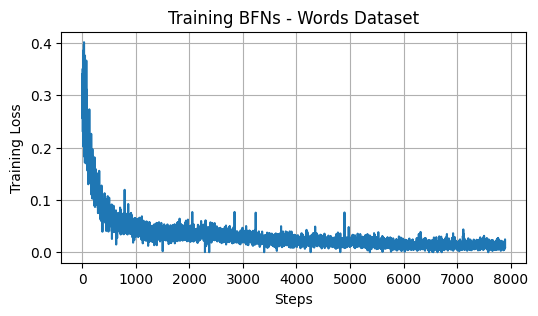

In [ ]:
logs = words_bayesian_flow.logs

plt.figure(figsize=(6, 3))
plt.xlabel("Steps")
plt.ylabel("Training Loss")
plt.title("Training BFNs - Words Dataset")
plt.grid()
plt.plot(logs["loss"])

In [ ]:
decode = lambda x: "".join([itos[idx] for idx in x])

In [ ]:
# Generated distribution with BFNs
words_samples = words_bayesian_flow.sample(batch_size=100).detach().cpu().numpy()
[decode(idxs) for idxs in words_samples]

['discrete    ',
 'network     ',
 'model       ',
 'network     ',
 'network     ',
 'fliw        ',
 'leibler     ',
 'kullback    ',
 'flcw        ',
 'continous   ',
 'kullback    ',
 'update      ',
 'kullback    ',
 'update      ',
 'flsw        ',
 'leibler     ',
 'leibler     ',
 'update      ',
 'network     ',
 'flkw        ',
 'fluw        ',
 'loss        ',
 'leibler     ',
 'model       ',
 'network     ',
 'model       ',
 'network     ',
 'loss        ',
 'leibler     ',
 'loss        ',
 'discrete    ',
 'fltw        ',
 'kullback    ',
 'continous   ',
 'kullback    ',
 'leibler     ',
 'model       ',
 'flsw        ',
 'kullback    ',
 'kullback    ',
 'networks    ',
 'flmw        ',
 'update      ',
 'update      ',
 'leibler     ',
 'flgw        ',
 'flgw        ',
 'loss        ',
 'leibler     ',
 'discrete    ',
 'flmw        ',
 'flcw        ',
 'leibler     ',
 'flgw        ',
 'networks    ',
 'loss        ',
 'loss        ',
 'leibler     ',
 'flsw        

#GENERACIÓN DE TEXTO USANDO WIKIQA CORPUS

In [ ]:
## PARTE DE GENERACIÓN DE TEXTO ##

## Para el entrenamiento se utiliza el dataset QnA de wikipedia. Se deja el link a la descarga en anexos
## En caso de querer subir el archivo y correr el entrenamiento, especificar directorio abajo
## Si se usa el directorio por defecto, es decir, cargando el archivo desde drive se puede dejar tal cual está


In [ ]:
# Imports
import pandas as pd
import os
import re
import torchtext
from torch.utils.data import Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
#
!unzip /content/drive/MyDrive/WikiQACorpus.zip

In [ ]:
#Chequeo de que efectivamente se están leyendo los archivos que vienen
# en el zip
for dirname, _, filenames in os.walk('/content/WikiQACorpus'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/WikiQACorpus/WikiQA-test.ref
/content/WikiQACorpus/WikiQA-dev-filtered.ref
/content/WikiQACorpus/WikiQASent.pos.ans.tsv
/content/WikiQACorpus/WikiQA-dev.txt
/content/WikiQACorpus/eval.py
/content/WikiQACorpus/Guidelines_Phase1.pdf
/content/WikiQACorpus/WikiQA-train.tsv
/content/WikiQACorpus/README.txt
/content/WikiQACorpus/WikiQA-test.tsv
/content/WikiQACorpus/WikiQA.tsv
/content/WikiQACorpus/WikiQA-test.txt
/content/WikiQACorpus/WikiQA-train.ref
/content/WikiQACorpus/WikiQA-test-filtered.ref
/content/WikiQACorpus/WikiQA-train.txt
/content/WikiQACorpus/WikiQA-dev.ref
/content/WikiQACorpus/LICENSE.pdf
/content/WikiQACorpus/Guidelines_Phase2.pdf
/content/WikiQACorpus/WikiQA-dev.tsv
/content/WikiQACorpus/emnlp-table/WikiQA.CNN-Cnt.test.rank
/content/WikiQACorpus/emnlp-table/WikiQA.CNN.dev.rank
/content/WikiQACorpus/emnlp-table/WikiQA.CNN.test.rank
/content/WikiQACorpus/emnlp-table/WikiQA.CNN-Cnt.dev.rank


In [ ]:
## Importación de archivo y definición dataframe con los datos
path_to_dataset  = "/content/WikiQACorpus/WikiQA-train.tsv"
df = pd.read_csv(path_to_dataset,sep='\t', header=0)

In [ ]:
df.head()

,QuestionID,Question,DocumentID,DocumentTitle,SentenceID,Sentence,Label
0,Q1,how are glacier caves formed?,D1,Glacier cave,D1-0,A partly submerged glacier cave on Perito More...,0
1,Q1,how are glacier caves formed?,D1,Glacier cave,D1-1,The ice facade is approximately 60 m high,0
2,Q1,how are glacier caves formed?,D1,Glacier cave,D1-2,Ice formations in the Titlis glacier cave,0
3,Q1,how are glacier caves formed?,D1,Glacier cave,D1-3,A glacier cave is a cave formed within the ice...,1
4,Q1,how are glacier caves formed?,D1,Glacier cave,D1-4,"Glacier caves are often called ice caves , but...",0


In [ ]:
#Funcion de preprocesamiento de texto

def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
    sentence = sentence.strip()
    # adding a start and an end token to the sentence
    # sentence = '<start> ' + sentence + ' <end>'
    return sentence

In [ ]:
pregunta = df["Question"]
respuesta = df['Sentence']

In [ ]:
#Preprocesar datos
preguntas=[]
respuestas=[]
for ques,ans in zip(pregunta,respuesta):
    preguntas.append(preprocess_sentence(ques))
    respuestas.append(preprocess_sentence(ans))

In [ ]:
#Veamos como se ve el dato antes de procesarlo y luego de procesarlo

In [ ]:
pregunta[0]

'how are glacier caves formed?'

In [ ]:
respuesta[0]

'A partly submerged glacier cave on Perito Moreno Glacier .'

In [ ]:
preguntas[0]

'how are glacier caves formed ?'

In [ ]:
respuestas[0]

'a partly submerged glacier cave on perito moreno glacier .'

In [ ]:
#cantidad de datos entrenamiento
print(len(preguntas))
print(len(respuestas))

20347
20347


####Intanciación nueva para pruebas en texto de la clase Bayesian flow network

In [ ]:
class DiscreteBayesianFlow2:
    def __init__ (self, model, K=2, D=2, n=100, beta=3.0, lr=1e-3, device="cpu"):
        self.device = device
        self.model = model.to(device)
        self.K = K
        self.D = D
        self.n = n
        self.beta = beta
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)

        self.logs = {}


    def get_beta(self, t):
        return self.beta * (t ** 2.0)


    def get_alpha(self, t):
        return self.beta * (2 * t - 1) / self.n ** 2


    def discrete_output_distribution(self, theta, t):
        theta = theta * 2 - 1
        output_nn = self.model(theta, t)
        output_nn = output_nn.view(output_nn.shape[0], self.D, -1)
        if self.K == 2:
            p_1 = torch.sigmoid(output_nn)
            p_2 = 1 - p_1
            p = torch.cat([p_1, p_2], dim=-1)
        else:
            p = nn.functional.softmax(output_nn, dim=-1)
        return p


    def continuous_loss(self, target):
        target = target.to(self.device)

        t = torch.clip(torch.randn((target.size(0),), requires_grad=False, device=self.device, dtype=torch.float32), 1e-5, 1.0)
        beta = self.get_beta(t)

        e_x = nn.functional.one_hot(target.long(), num_classes=self.K).float()
        y_mean = beta[..., None, None] * (self.K * e_x - 1)
        y_std = (beta * self.K).sqrt()[:, None, None]
        eps = torch.randn_like(y_mean).to(self.device)

        y = y_mean + y_std * eps

        theta = nn.functional.softmax(y, dim=-1)
        p_o = self.discrete_output_distribution(theta, t)

        e_hat = p_o
        l_infinity = self.K * self.beta * t[..., None, None] * (e_x - e_hat) ** 2
        l_infinity = l_infinity.mean()
        return l_infinity


    def sample(self, batch_size=64):
        self.model.eval()
        theta = torch.ones((batch_size, self.D, self.K), device=self.device) / self.K

        for i in range(1, self.n+1):
            t = (i - 1) / self.n
            t = t * torch.ones(batch_size, device=self.device, dtype=theta.dtype)
            p_o = self.discrete_output_distribution(theta, t)
            k = torch.distributions.Categorical(probs=p_o).sample()
            alpha = self.get_alpha(i)

            e_k = nn.functional.one_hot(k, num_classes=self.K).float()
            y_mean = alpha * (self.K * e_k - 1)
            y_std = torch.full_like(y_mean, fill_value=(alpha * self.K)).sqrt()
            eps = torch.randn_like(y_mean).to(self.device)
            y = y_mean + y_std * eps
            theta = nn.functional.softmax(y + torch.log(theta + 1e-10), dim=-1)

        p_o = self.discrete_output_distribution(theta, torch.ones_like(t))
        k = torch.distributions.Categorical(probs=p_o).sample()
        return k


    def train(self, dataloader, epochs=20):
        self.logs["loss"] = []
        self.logs["step"] = []
        step = 0
        for epoch in range(epochs):
            for batch in dataloader:
                self.model.zero_grad()
                X = batch['input']
                loss = self.continuous_loss(X)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1)
                self.optimizer.step()
                step += 1

                # logs
                self.logs["loss"].append(loss.item())
                self.logs["step"].append(step)
        # plt.plot(losses)

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torchtext

# Concatenar preguntas y respuestas en un solo corpus
corpus = preguntas + respuestas

# Tokenizador subpalabra
tokenizer = torchtext.data.utils.get_tokenizer('basic_english')
corpus_tokens = [tokenizer(sentence) for sentence in corpus]

# Construir el vocabulario
vocab = torchtext.vocab.build_vocab_from_iterator(corpus_tokens, specials=["<start>", "<end>"])

# Tamaño del vocabulario
VOCAB_SIZE = len(vocab)

# Imprimir el vocabulario
print("Vocabulario:", vocab.get_itos())

# Imprimir el tamaño del vocabulario
print("Tamaño del vocabulario:", VOCAB_SIZE)

# Función para convertir tokens a índices
def tokens_to_indices(tokens, vocab):
    return [vocab[token] for token in tokens]

# Función para preparar pares de entrada y salida
def prepare_data_pairs(corpus, vocab):
    data_pairs = []
    for i in range(0, len(corpus)-1, 2):
        pregunta = tokens_to_indices(["<start>"] + corpus[i], vocab)
        respuesta = tokens_to_indices(corpus[i+1] + ["<end>"], vocab)
        data_pairs.append((pregunta, respuesta))
    return data_pairs

# Clase Dataset personalizado
class QADataset(Dataset):
    def __init__(self, data_pairs):
        self.data_pairs = data_pairs

    def __len__(self):
        return len(self.data_pairs)

    def __getitem__(self, index):
        pregunta, respuesta = self.data_pairs[index]
        return {
            'input': torch.tensor(pregunta, dtype=torch.long),
            'target': torch.tensor(respuesta, dtype=torch.long)
        }

# Preparar pares de entrada y salida
data_pairs = prepare_data_pairs(corpus_tokens, vocab)

# Crear el Dataset personalizado
dataset = QADataset(data_pairs)

# Crear el DataLoader con pad_sequence
def collate_fn(batch):
    input_data = [item['input'] for item in batch]
    target_data = [item['target'] for item in batch]

    # Aplicar padding a las secuencias
    input_data_padded = pad_sequence(input_data, batch_first=True)
    target_data_padded = pad_sequence(target_data, batch_first=True)

    return {'input': input_data_padded, 'target': target_data_padded}

batch_size = 64
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)


Vocabulario: ['<start>', '<end>', 'the', ',', '.', 'of', 'in', 'and', 'is', 'a', 'what', 'to', 'was', 'as', 'for', 's', 'are', 'how', 'by', 'on', 'with', 'who', '?', 'or', 'from', 'it', 'when', 'an', 'that', 'many', 'did', 'where', 'does', 'at', 'has', 'states', 'which', 'have', 'be', 'his', 'first', 'united', 'world', 'also', 'were', 'war', 'most', 'he', 'one', 'its', 'used', 'do', 'new', 'other', 'this', 'american', 'not', 'been', 'their', 'can', 'such', 'after', 'all', 'known', 'made', 'state', 'into', 'two', 'more', 'time', 'but', 'year', 'some', 'may', 'president', 'name', 'they', 'during', 'people', 'over', 'about', 'u', 'series', 'than', 'there', 'city', 'had', 'use', 'th', 'only', 'much', 'number', 'part', 'between', 'national', 'film', 'her', 'countries', 'system', 'us', 'years', 'since', 'i', 'called', 'including', 'country', 'often', 'million', 'america', 'major', 'john', 'game', 'these', 'well', 'three', 'largest', 'second', 'population', 'up', 'civil', 'born', 'day', 'four

In [ ]:
bayesian_flow2 = DiscreteBayesianFlow2(model=model, device=device)
bayesian_flow2.train(dataloader, epochs=100)

RuntimeError: ignored

#Generación de texto frases cortas
